In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import os

# Over/Undersampling
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
nr = NearMiss() 
sm = SMOTE()


In [2]:
# Import data
df = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/CLA_RF_input.csv')
df.head()

,Male?,FSM,SMC,Disabled?,White_British?,Number_contacts,Number_referrals,Number_assessments,Number_strategies,Number_S47s,Number_ICPCs,Number_CIN_plans,Number_CP_plans,CLA,Residential_CLA
0,0,1,0,0,1,0,9,0,1,1,1,3,2,1,0
1,1,1,0,0,1,0,3,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,4,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0


In [3]:
# Set independent and dependent variables
df = df.drop(['Male?'], axis=1) # Drop any factors that might not be useful
X = df.drop(['CLA','Residential_CLA'], axis=1)
y = df['CLA'] # Target variable
X.head()

,FSM,SMC,Disabled?,White_British?,Number_contacts,Number_referrals,Number_assessments,Number_strategies,Number_S47s,Number_ICPCs,Number_CIN_plans,Number_CP_plans
0,1,0,0,1,0,9,0,1,1,1,3,2
1,1,0,0,1,0,3,0,0,0,0,0,0
2,0,0,0,1,0,4,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0
4,0,0,1,1,0,1,0,0,0,0,0,0


In [4]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

rf = RandomForestClassifier() # No arguments until we're ready to tune hyperparameters

# Train the classifier on the training data
rf = rf.fit(X_train, y_train)

# Check how well the classifier fits the test data
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)
print('Balanced accuracy: ', balanced_accuracy)

print("Before Under/Oversampling, counts of CLA: {}".format(sum(y_train == 1))) 
print("Before Under/Oversampling, counts of not CLA: {} \n".format(sum(y_train == 0))) 

Accuracy:  0.968964375266121
Balanced accuracy:  0.6769171518978516
Before Under/Oversampling, counts of CLA: 5969
Before Under/Oversampling, counts of not CLA: 141987 



In [5]:
# Undersample those who are not CLAs OR Oversample those who are CLAs
sample_type = 'under'

if sample_type == 'under':
    X_train_samp, y_train_samp = nr.fit_resample(X_train, y_train.ravel())
    print('After Undersampling, the shape of train_X: {}'.format(X_train_samp.shape))
    print('After Undersampling, the shape of train_y: {} \n'.format(y_train_samp.shape))
    print("After Undersampling, counts of label '1': {}".format(sum(y_train_samp == 1)))
    print("After Undersampling, counts of label '0': {}".format(sum(y_train_samp == 0)))

    # Train the classifier on the training data
    rf_sampled = RandomForestClassifier()
    rf_sampled = rf_sampled.fit(X_train_samp, y_train_samp)

    # Check how well the classifier fits the test data
    y_pred = rf_sampled.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)
    print('Balanced accuracy: ', balanced_accuracy)

elif sample_type == 'over':
    X_train_samp, y_train_samp = sm.fit_resample(X_train, y_train) 
    print('After Oversampling, the shape of train_X: {}'.format(X_train_samp.shape))
    print('After Oversampling, the shape of train_y: {} \n'.format(y_train_samp.shape))
    print("After Oversampling, counts of label '1': {}".format(sum(y_train_samp == 1)))
    print("After Oversampling, counts of label '0': {}".format(sum(y_train_samp == 0)))

    # Train the classifier on the training data
    rf_sampled = RandomForestClassifier()
    rf_sampled = rf_sampled.fit(X_train_samp, y_train_samp)

    # Check how well the classifier fits the test data
    y_pred = rf_sampled.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)
    print('Balanced accuracy: ', balanced_accuracy)

After Undersampling, the shape of train_X: (11938, 12)
After Undersampling, the shape of train_y: (11938,) 

After Undersampling, counts of label '1': 5969
After Undersampling, counts of label '0': 5969
Accuracy:  0.6431849363675072
Balanced accuracy:  0.7304889382266633


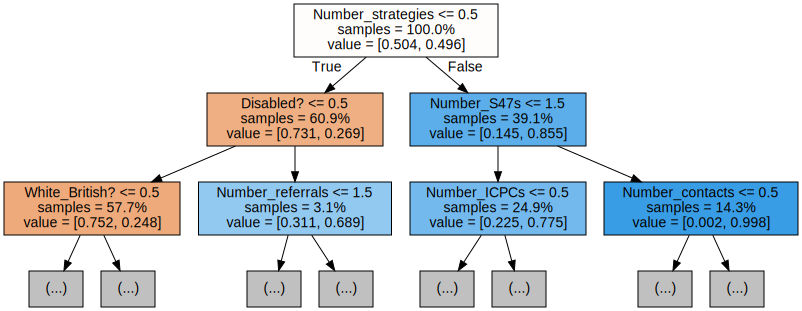

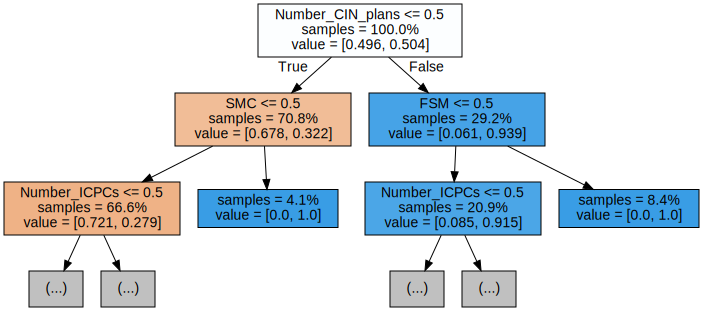

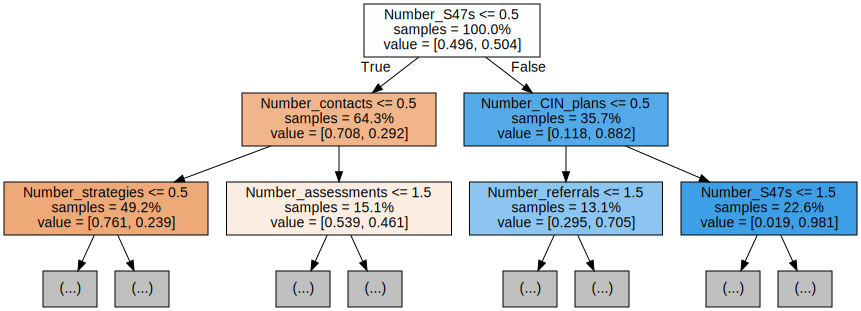

In [6]:
for i in range(3):
    tree = rf_sampled.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


In [7]:
# Tuning hyperparameters
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_tuning = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_tuning, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_samp, y_train_samp)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7d7e36e5f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f7d7e36c280>})

In [8]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 460}


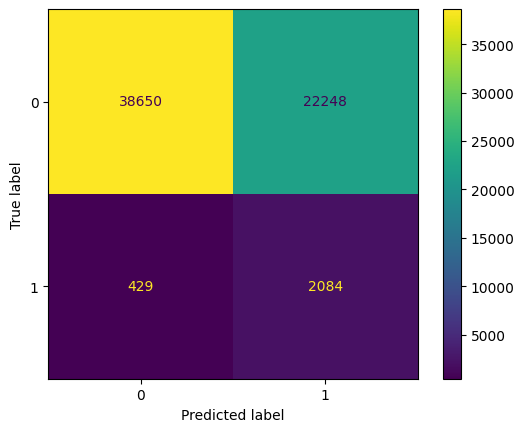

In [9]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

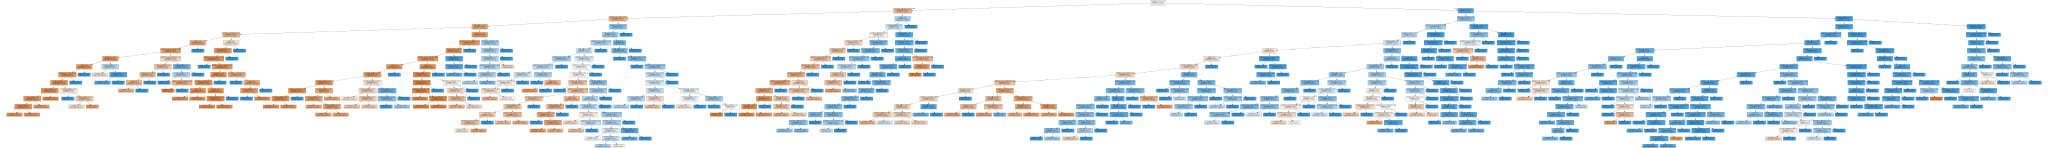

In [10]:
# Display best model
from six import StringIO 
from IPython.display import Image  
import pydotplus

feature_cols = list(X.columns.values)

tree = best_rf.estimators_[1]
dot_data = export_graphviz(tree,
                            feature_names=X_train.columns,  
                            filled=True,  
                            #max_depth=2, 
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

# dot_data = StringIO()
# export_graphviz(best_rf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols, class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('CLA.png')
# Image(graph.create_png())

In [11]:
# Use k-nearest neighbours to look at how important factors we have used in our decision tree are to outcomes

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_samp, y_train_samp)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Balanced accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7619498194319597
Balanced accuracy: 0.7494019799463232
Precision: 0.11357493857493857
Recall: 0.7357739753282929


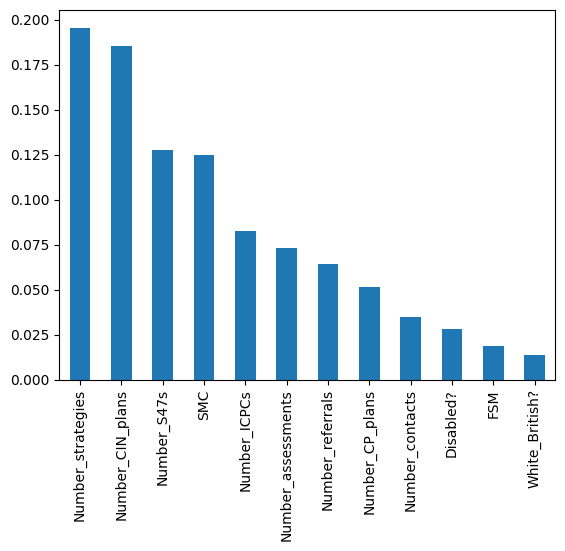

In [12]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train_samp.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();